# Video Activity Classifier Workshop

In this workshop, we will be training a classifier using body positions extracted from video.

![photo](assets/istockphoto-476741742.jpg)

This follows up from [04_pose_estimation.ipynb](04_pose_estimation.ipynb).

In [5]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
import numpy as np
from sklearn.metrics.pairwise import paired_distances

# requires: conda install opencv
import cv2

plt.style.use('seaborn-white')

In [27]:
# Source: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#pose-output-format-coco
Pose_part_pairs = [
    (1,8), (1,2), (1,5), (2,3), (3,4), (5,6), (6,7), (8,9), (9,10), (10,11),
    (8,12), (12,13), (13,14), (1,0), (0,15), (15,17), (0,16), (16,18), (2,17), (5,18),
    (14,19), (19,20), (14,21), (11,22), (22,23), (11,24)
]

def draw_skeleton(ax, df):
    """Connects keypoints into a skeleton"""
    for p, q in Pose_part_pairs:
        if df.x[p] != 0 and df.x[q] != 0 and df.y[p] != 0 and df.y[q] != 0:
            ax.plot([df.x[p], df.x[q]], [df.y[p], df.y[q]], color='red')

def keypoints_to_dataframe(keypoints):
    """Converts a flat keypoints list (x1, y1, c1, x2, y2, c2) into a pandas DataFrame"""
    return pd.DataFrame({'x': keypoints[::3], 'y': keypoints[1::3], 'c': keypoints[2::3]})

def get_centroid(coordinates, threshold=0.1):
    """Computes the centroid of a given 2 dimensional vector"""
    x = coordinates[coordinates.c > threshold].x
    y = coordinates[coordinates.c > threshold].y
    
    return [sum(x)/len(x), sum(y)/len(y)]

def get_centroids(frame):
    """Returns the centroid for each person as a list of (x, y) coordinates"""
    return np.array([get_centroid(keypoints_to_dataframe(person['pose_keypoints_2d'])) for person in frame['people']])

def get_closest_index(centroid, other_frame):
    """Find closest index in other_frame from a given centroid"""
    other_centroids = get_centroids(other_frame)
    return np.argmin(paired_distances(np.ones(other_centroids.shape) * centroid, other_centroids))

def get_part_candidates_as_features(frame):
    """Get the part keypoints as features
    BODY_25 format:
    https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#keypoint-ordering-in-cpython
        //     {0,  "Nose"},
        //     {1,  "Neck"},
        //     {2,  "RShoulder"},
        //     {3,  "RElbow"},
        //     {4,  "RWrist"},
        //     {5,  "LShoulder"},
        //     {6,  "LElbow"},
        //     {7,  "LWrist"},
        //     {8,  "MidHip"},
        //     {9,  "RHip"},
        //     {10, "RKnee"},
        //     {11, "RAnkle"},
        //     {12, "LHip"},
        //     {13, "LKnee"},
        //     {14, "LAnkle"},
        //     {15, "REye"},
        //     {16, "LEye"},
        //     {17, "REar"},
        //     {18, "LEar"},
        //     {19, "LBigToe"},
        //     {20, "LSmallToe"},
        //     {21, "LHeel"},
        //     {22, "RBigToe"},
        //     {23, "RSmallToe"},
        //     {24, "RHeel"},
        //     {25, "Background"}    
    """
    # 0_x, 0_y, 0_confidence, 1_x, 1_y, 1_confidence,
    
    pass


def plot_keypoints(video_path, keypoints_path, frame_first, frame_step, max_frame_last):
    """Displays the keypoints overlaid on the video"""
    video = cv2.VideoCapture(video_path)

    # fast forward video to frame_first
    for i in range(frame_first):
        _, image = video.read()

    frame = json.load(open(f'{keypoints_path}_{frame_first:012d}_keypoints.json', 'rb'))
    df = keypoints_to_dataframe(frame['people'][0]['pose_keypoints_2d'])
    centroid = get_centroid(df)

    # Create the matplotlib axes
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), sharex=True, sharey=True)
    ax = ax.flatten()

    for i, t in zip(range(len(ax)), range(frame_first, frame_last, frame_step)):
        _, image = video.read()

        frame = json.load(open(f'{keypoints_path}_{t:012d}_keypoints.json', 'rb'))
        index = get_closest_index(centroid, frame) # find the closest person

        # load keypoints for the closest person
        df = keypoints_to_dataframe(frame['people'][index]['pose_keypoints_2d'])

        axis = ax[i]
        axis.scatter(df.x, df.y, s=df.c*10, color='yellow')
        axis.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axis.set(title=f'Frame {t}')
        draw_skeleton(axis, df)

        centroid = get_centroid(df) # update centroid since person may have moved

## Extract keypoints from the videos using OpenPose

A subset of the keypoints (for the first 10 frames) have been provided. However, we should use more data to train the model.

Follow these steps to extract more keypoints.

1. Modify the paths under `HSS_DIR` and `OPENPOSE_DIR`.

2. Run the code below which calls OpenPoseDemo to extract the keypoints from the data videos.

In [18]:
import glob
import os

############# CHANGE BELOW PATH ################
HSS_DIR = r'D:\S-HSS\Workshop\hss'
############# CHANGE ABOVE PATH ################

############# CHANGE BELOW PATH ################
OPENPOSE_DIR = r'D:\S-HSS\Workshop\openpose-1.5.1-binaries-win64-only_cpu-python-flir-3d\openpose'
############# CHANGE ABOVE PATH ################

classes = ['awake', 'sleep']

frame_first = 20
frame_step = 1
frame_last = 50

cwd = os.getcwd()
os.chdir(OPENPOSE_DIR)
for c in classes:
    data_path = os.path.join(HSS_DIR, r'data\dozing', c)
    files = glob.glob(os.path.join(data_path, '*.avi'))
    
    for f in files:
        name, _ = f.split('.')
        input_path = os.path.join(data_path, f)
        output_path = os.path.join(data_path, name)

        cmd = f'bin\\OpenPoseDemo.exe --part_candidates --write_json {output_path} --video {input_path} \
--frame_first {frame_first} --frame_step {frame_step} --frame_last {frame_last}'
        print(cmd)
        os.system(cmd)

os.chdir(cwd)

bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\1 --video D:\S-HSS\Workshop\hss\data\dozing\awake\1.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\2 --video D:\S-HSS\Workshop\hss\data\dozing\awake\2.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\awake\3 --video D:\S-HSS\Workshop\hss\data\dozing\awake\3.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\sleep\1 --video D:\S-HSS\Workshop\hss\data\dozing\sleep\1.avi         --frame_first 20 --frame_step 1 --frame_last 50
bin\OpenPoseDemo.exe --part_candidates --write_json D:\S-HSS\Workshop\hss\data\dozing\sleep\2 --video D:\S-HSS\Workshop\hss\data\dozing\sleep\2.avi         --frame_first 20 --frame_ste

## Examine the keypoints

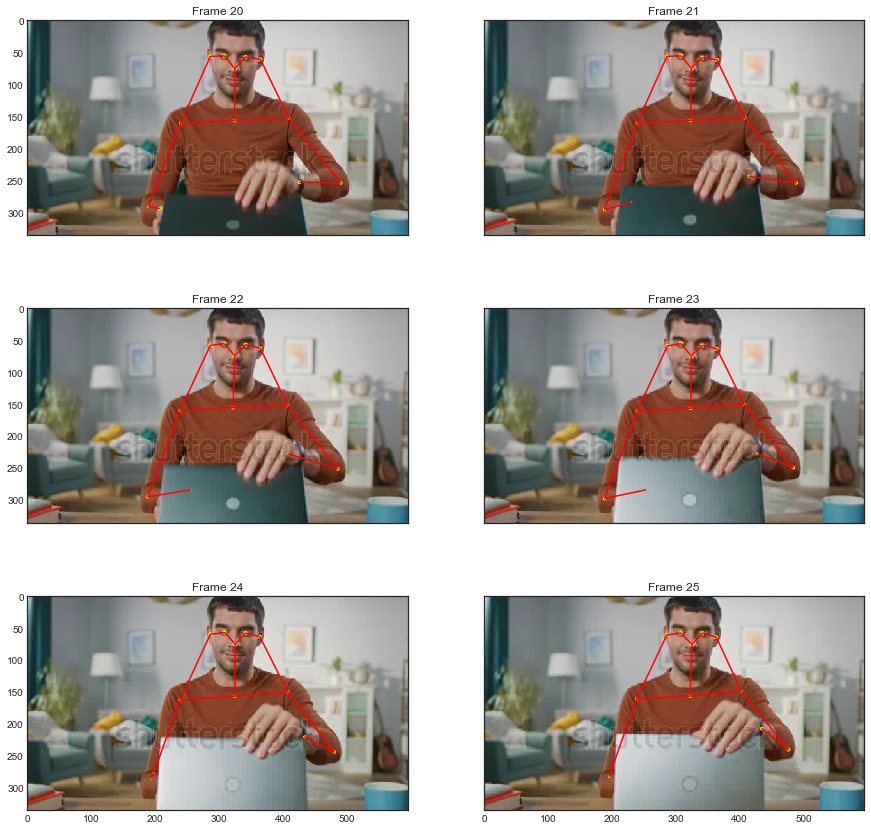

In [32]:
def plot_sample(classname, sample_index):
    data_path = os.path.join(HSS_DIR, r'data\dozing', classname)
    video_path = os.path.join(data_path, f'{sample_index}.avi')
    keypoints_path = os.path.join(data_path, str(sample_index), str(sample_index))

    frame_first = 20
    frame_step = 1
    frame_last = 50

    plot_keypoints(video_path, keypoints_path, frame_first, frame_step, max_frame_last=frame_last)

plot_sample('awake', 1)

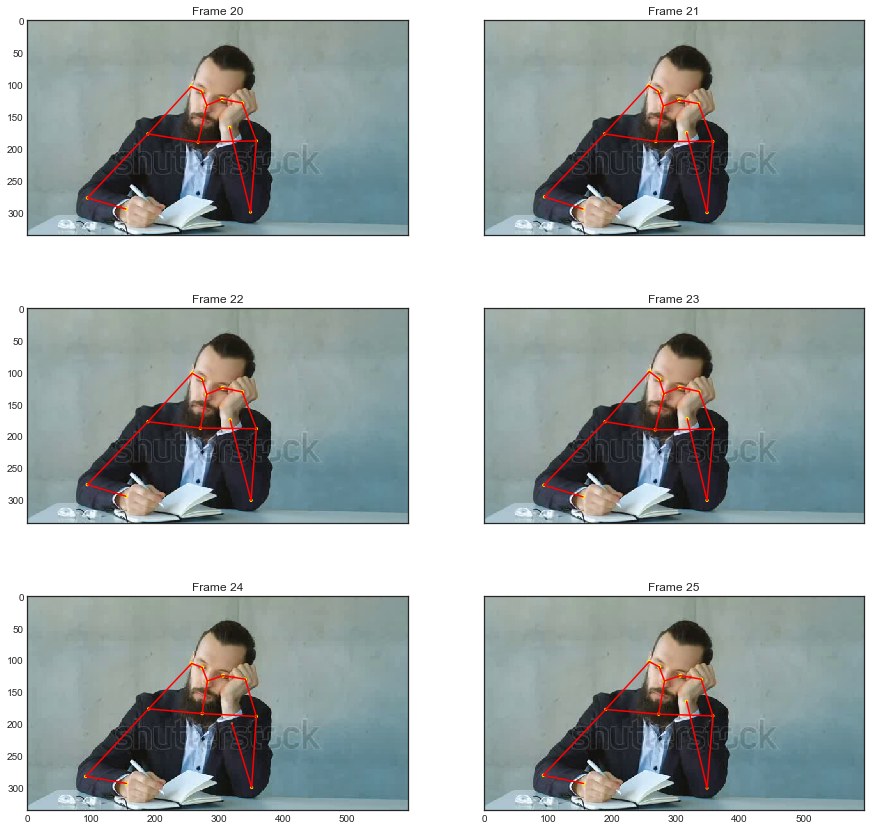

In [33]:
plot_sample('sleep', 1)